In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import glob
import scanpy as sc 

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# local imports
source_path = os.path.abspath("../utilities/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import matrix as matrix
import centrality as central
import curvature as curv

# Load Data

In [2]:
%%time 
resolution = 100000
chrom = "chr2"

dpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/pipeline_outputs/higher_order/by_chromosome/"

file_list = sorted(glob.glob(f"{dpath}population*_{resolution}_{chrom}*"))
fpath = file_list[0]

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
adata

Memory usage: current 0.76 GB, difference +0.76 GB
CPU times: user 1.06 s, sys: 248 ms, total: 1.31 s
Wall time: 1.5 s


/nfs/turbo/umms-indikar/Cooper/conda_envs/pore_c/lib/python3.13/site-packages/anndata/logging.py:57: FutureWarning: The specified parameters ('newline',) are no longer positional. Please specify them like `newline=False`
  print(format_memory_usage(get_memory_usage(), msg, newline))


AnnData object with n_obs × n_vars = 1787 × 202857
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'PolII', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

# Make incidence

In [3]:
%%time
H = adata.to_df().copy()
H = H.T.drop_duplicates().T
print(f"raw: {H.shape=}")

# # remove outlier bins (promiscuous )
# s = H.select_dtypes('number').sum(axis=1)
# q1, q3 = s.quantile([0.25, 0.75]); iqr = q3 - q1
# keep = s.between(q1 - 1.5*iqr, q3 + 1.5*iqr)
# H = H[keep]

# now drop newly created singletons
H = H.loc[:, H.sum(0) >= 2]

# drop disgusting hyperedges
H = H.loc[:, H.sum(0) <= 10]

print(f"filtered: {H.shape=}")

H.head()

raw: H.shape=(1787, 121872)
filtered: H.shape=(1787, 121501)
CPU times: user 9.57 s, sys: 5.35 s, total: 14.9 s
Wall time: 15 s


read_name,3db453c3-be68-417e-bf3f-7d660af7d1aa,2e567d50-8451-4643-a981-1cd91a0062c0,32e53ef8-c394-4db7-bb72-e29a3281a26f,3b0686b6-f18f-495d-89f5-8c8b286c2bb1,ef7ff38e-a5fe-4692-b270-9a704ffa2981,b079fedb-5786-48f4-a0f4-f0e72b85a88f,745fba62-0407-4d47-8c72-122014aa5c56,dc63595a-de81-4976-b052-4f514babc44a,b40b53f2-eb37-4ab7-81c8-ba08d8fd43eb,c7e3608d-c42b-4c51-a1be-c8944d9746a5,...,3ae04997-f3dc-474a-8816-8e69e34991a9,5d1aa61e-48e7-4405-9b9a-58e0d230fb7f,0a70ae47-a7fc-43a8-b4f4-48bfa6baf150,0cc4844b-a178-468d-80a1-60bada11b821,45c6a088-2ab4-45c6-856f-12b1a508d94b,50de958b-9a35-4f47-ae81-b248a7edeac5,dc0b7b0b-4a14-49a2-8e48-8416b44f8996,851fee48-7d5e-4de9-9f76-234f2727d0df,ab473b94-fd20-41ed-84d3-e2453b279729,c26a58f7-0a8c-44e8-bbcc-0bddace54970
bin_name,,,,,,,,,,,,,,,,,,,,,
chr2:30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr2:31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr2:32,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr2:33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr2:34,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


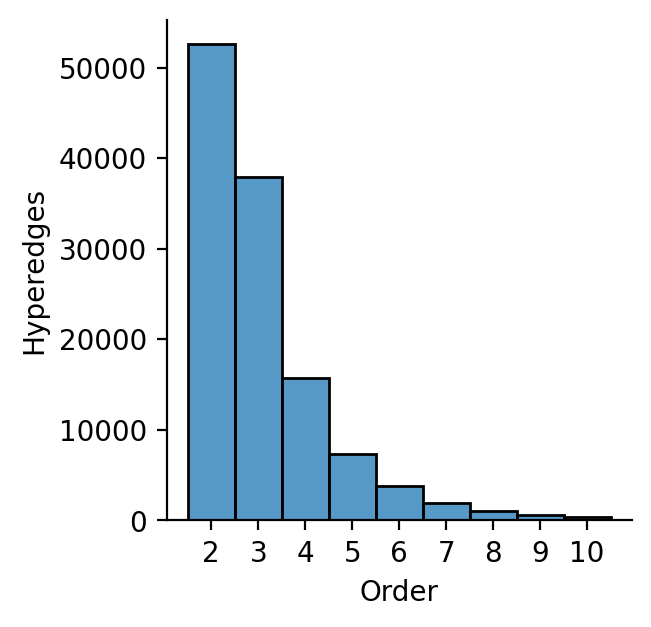

In [4]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3.25

x = H.sum(0)
sns.histplot(x, discrete=True, bins=range(int(x.min()), int(x.max())+2))
plt.xticks(range(int(x.min()), int(x.max())+1))

plt.ylabel('Hyperedges')
plt.xlabel('Order')

sns.despine()

# Node Centrality

CPU times: user 102 ms, sys: 9.26 ms, total: 111 ms
Wall time: 120 ms


,ATACSeq,CTCF,H3K27ac,H3K27me3,RNA,PolII
bin_name,,,,,,
chr2:30,0.156989,0.139334,0.071030,0.295131,0.010266,0.053354
chr2:31,0.828887,0.511249,0.291918,0.838052,0.267153,0.250421
chr2:32,0.734521,0.371129,0.317039,0.703940,0.392459,0.326268
chr2:33,0.678280,0.521163,0.394619,0.579685,0.864406,0.487997
chr2:34,0.834263,0.462664,0.512297,0.468104,0.925120,0.731644


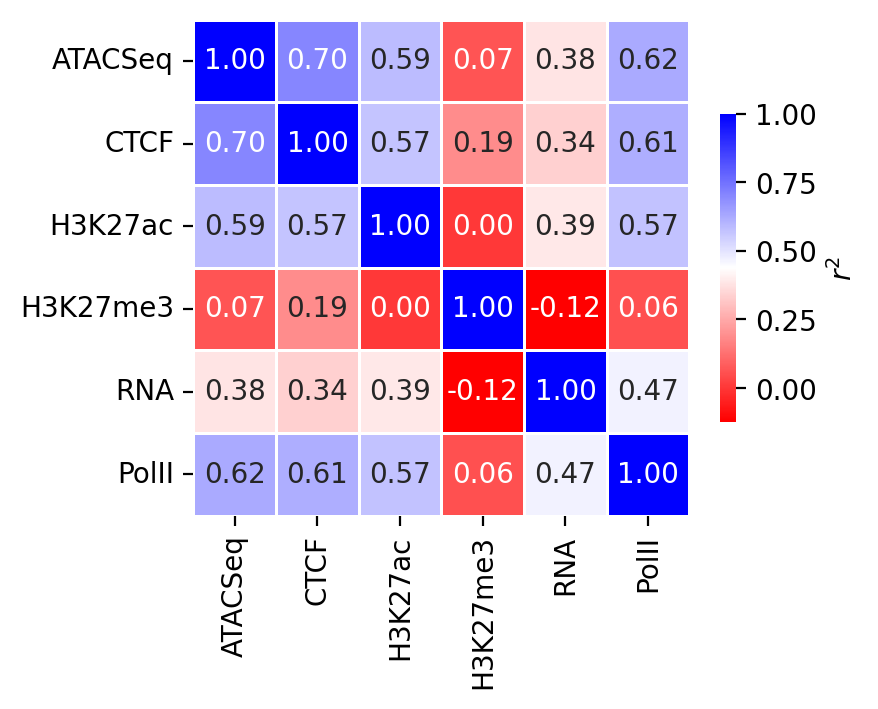

In [5]:
%%time

# set up node features
fields = [
    'ATACSeq_1', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_5', 'PolII',
]

ndf = adata.obs[fields].copy()
ndf.columns = [x.split("_")[0] for x in ndf.columns]
features = ndf.columns

# Step 1: fill NaN with column medians
ndf = ndf.apply(lambda col: col.fillna(col.median()), axis=0)

# Step 2: replace outliers with column median (IQR method)
for col in ndf.columns:
    Q1 = ndf[col].quantile(0.25)
    Q3 = ndf[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    median = ndf[col].median()
    ndf[col] = np.where((ndf[col] < lower) | (ndf[col] > upper), median, ndf[col])


# Step 3: min_max
ndf = ndf.apply(lambda col: ut.min_max(col), axis=0)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4
sns.heatmap(
    ndf.corr(),
    square=True,
    cbar_kws={'shrink' : 0.5, 'label' : r'$r^2$'},
    lw=1,
    annot=True,
    fmt=".2f",                     # 2 decimals
    cmap='bwr_r',
)

ndf.head()

In [6]:
ndf.head()

,ATACSeq,CTCF,H3K27ac,H3K27me3,RNA,PolII
bin_name,,,,,,
chr2:30,0.156989,0.139334,0.071030,0.295131,0.010266,0.053354
chr2:31,0.828887,0.511249,0.291918,0.838052,0.267153,0.250421
chr2:32,0.734521,0.371129,0.317039,0.703940,0.392459,0.326268
chr2:33,0.678280,0.521163,0.394619,0.579685,0.864406,0.487997
chr2:34,0.834263,0.462664,0.512297,0.468104,0.925120,0.731644


[INFO] Starting centrality computation for 12 (function × field) runs...
[INFO] Function = lin (linear)
  [1/12] Processing field: ATACSeq -> lin_ATACSeq
  [2/12] Processing field: CTCF -> lin_CTCF
  [3/12] Processing field: H3K27ac -> lin_H3K27ac
  [4/12] Processing field: H3K27me3 -> lin_H3K27me3
  [5/12] Processing field: RNA -> lin_RNA
  [6/12] Processing field: PolII -> lin_PolII
[DONE] All centrality columns added.
CPU times: user 18.7 s, sys: 346 ms, total: 19 s
Wall time: 19.1 s


<Axes: >

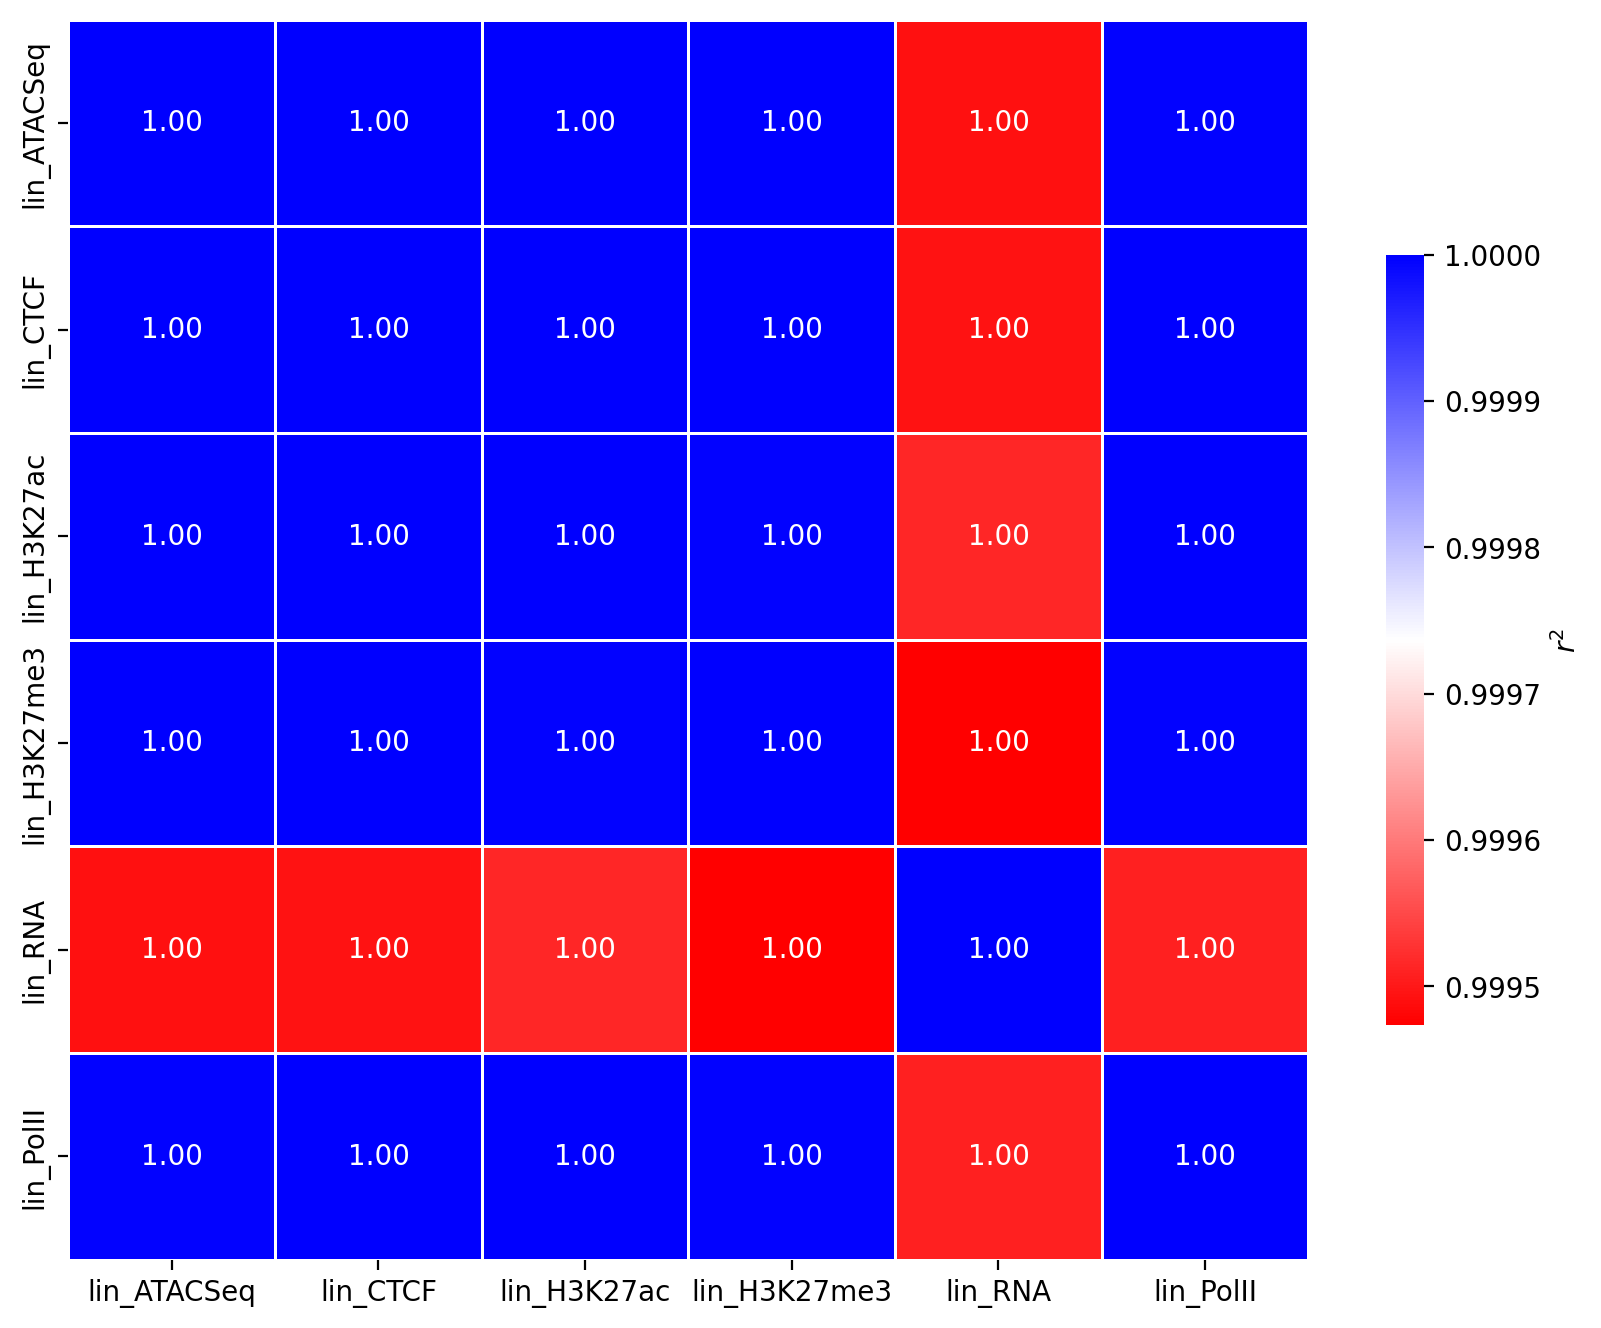

In [7]:
%%time
funcs = {
    'lin' : 'linear',  # nodes in higher-order hyperedges are more central 
    'le' : 'log-exp', # nodes in lower-order hyperedges are more central
}

ec_columns = []
total = len(funcs) * len(features)
count = 0

print(f"[INFO] Starting centrality computation for {total} (function × field) runs...")

for func_name, func in funcs.items():
    print(f"[INFO] Function = {func_name} ({func})")
    for field in features:
        count += 1
        column_name = f"{func_name}_{field}"
        ec_columns.append(column_name)

        print(f"  [{count}/{total}] Processing field: {field} -> {column_name}")
        node_ev, _ = central.hevc(
            H, function=func, 
            node_weights=ndf[field].to_numpy(),
        )
        ndf[column_name] = ut.min_max(node_ev)
    break

print("[DONE] All centrality columns added.")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10
sns.heatmap(
    ndf[ec_columns].corr(),
    square=True,
    cbar_kws={'shrink' : 0.5, 'label' : r'$r^2$'},
    lw=1,
    annot=True,
    fmt=".2f",                     # 2 decimals
    cmap='bwr_r',
)


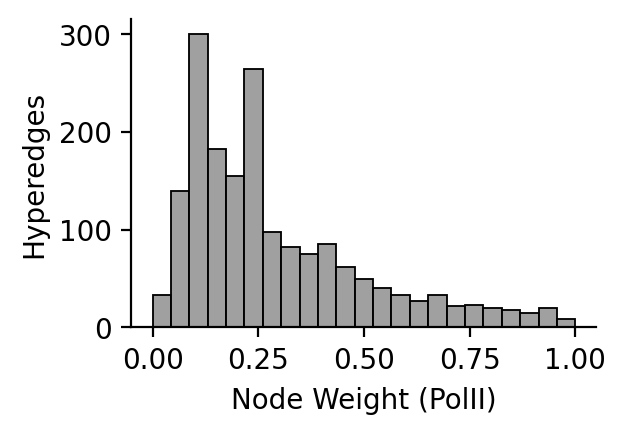

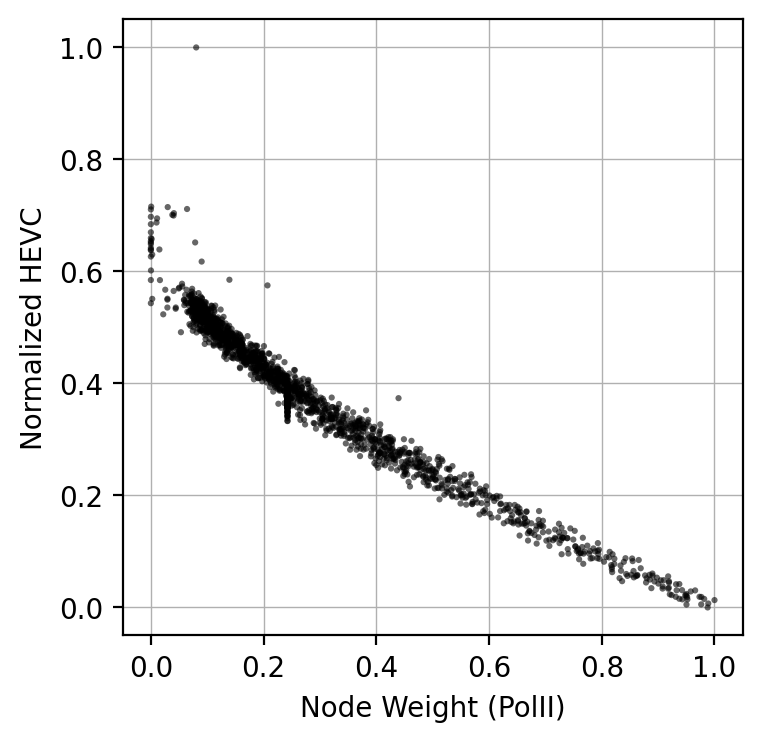

ATACSeq        -0.68
CTCF           -0.67
H3K27ac        -0.60
H3K27me3       -0.11
RNA            -0.46
PolII          -0.97
lin_ATACSeq     0.11
lin_CTCF        0.11
lin_H3K27ac     0.11
lin_H3K27me3    0.11
lin_RNA         0.10
lin_PolII       0.10
hevc            1.00
hevc_norm       1.00
CPU times: user 2.85 s, sys: 54.4 ms, total: 2.9 s
Wall time: 2.91 s


In [8]:
%%time

node_weight = 'PolII'
weights = ndf[node_weight].to_numpy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2
sns.histplot(
    weights,
    color='gray',
)
plt.ylabel('Hyperedges')
plt.xlabel(f'Node Weight ({node_weight})')
sns.despine()
plt.show()


node_ev, _ = central.hevc(
    H, 
    function='log-exp', # nodes in lower-order hyperedges are more central
    node_weights=weights,
)


ndf['hevc'] = list(node_ev)
ndf['hevc_norm'] = ut.min_max(node_ev)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

# Scatter
sns.scatterplot(
    data=ndf,
    x=node_weight,
    y='hevc_norm',
    s=5, ec='none',
    alpha=0.6, c='k',
    zorder=10,
)

plt.grid(zorder=0, lw=0.5,)
# plt.xscale('log')
plt.xlabel(f'Node Weight ({node_weight})')
plt.ylabel('Normalized HEVC')
plt.show()

print(ndf.corr()['hevc_norm'].round(2).to_string())

# Edge Centrality

In [9]:
B = H.copy()
print(f"{B.shape=}")

B.shape=(1787, 121501)


In [10]:
%%time
# HEVC
node_ev, edge_ev = central.hevc(B, function='linear')
print(f"{len(node_ev)=} {type(node_ev)=}")
print(f"{len(edge_ev)=} {type(edge_ev)=}")

len(node_ev)=1787 type(node_ev)=<class 'numpy.ndarray'>
len(edge_ev)=121501 type(edge_ev)=<class 'numpy.ndarray'>
CPU times: user 2.69 s, sys: 2.48 ms, total: 2.69 s
Wall time: 2.7 s


In [11]:
%%time
# HLRC
blist = ut.incidence_to_list_of_list(B)
hlrc = curv.compute_hlrc(blist)
print(f"{len(hlrc)=} {type(hlrc)=}")

len(hlrc)=121501 type(hlrc)=<class 'list'>
CPU times: user 4.88 s, sys: 44.1 ms, total: 4.92 s
Wall time: 4.94 s


In [12]:
%%time
# FRC
frc = curv.compute_forman_curvature(B)
print(f"{len(frc)=} {type(frc)=}")

len(frc)=121501 type(frc)=<class 'pandas.core.series.Series'>
CPU times: user 52min 37s, sys: 19.7 s, total: 52min 57s
Wall time: 53min 6s


In [13]:
%%time
df = pd.DataFrame({
    'hevc' : list(edge_ev),
    'hlrc' : list(hlrc),
    'frc' : list(frc),
})

print(f"{df.shape=}")
print(df.head().to_string())
print()

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
df[df.columns] = scaler.fit_transform(df[df.columns])
print(df.head().to_string())

df.shape=(121501, 3)
           hevc      hlrc      frc
0  4.112275e-05  0.148376 -24018.0
1  1.433795e-07 -0.341325   -425.0
2  4.117071e-05 -0.850601 -24205.0
3  4.111083e-05  0.203807 -24029.0
4  1.501860e-07 -0.919217   -510.0

       hevc      hlrc       frc
0  0.959316  0.769986 -0.796572
1 -0.994772  0.005074  0.977071
2  0.961603 -0.790415 -0.810630
3  0.958748  0.856569 -0.797399
4 -0.994447 -0.897592  0.970681
CPU times: user 46.5 ms, sys: 9.68 ms, total: 56.1 ms
Wall time: 55.5 ms


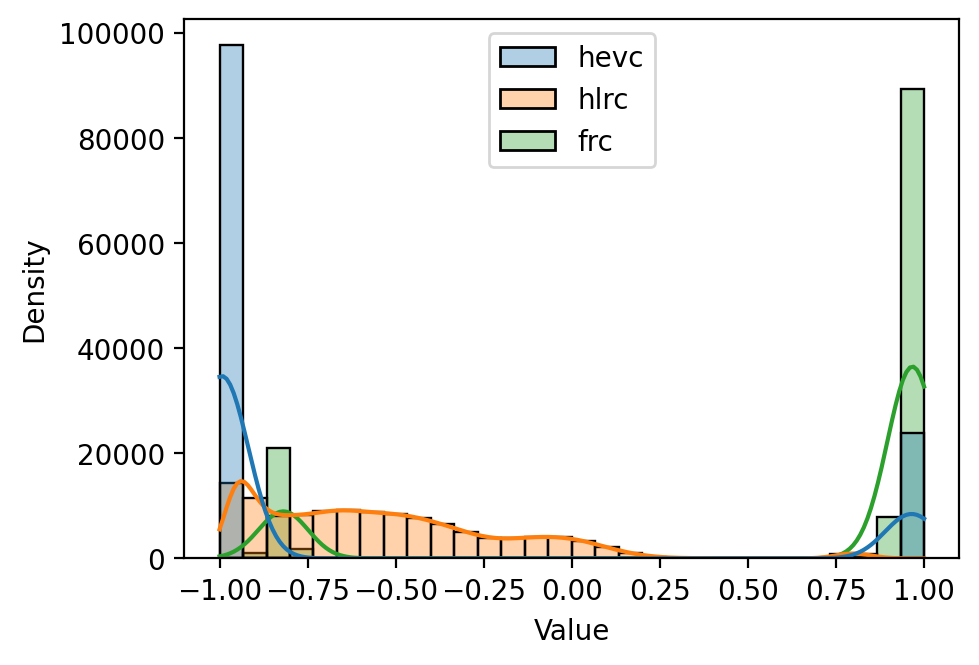

In [20]:

cols = ['hevc', 'hlrc', 'frc']
long = df[cols].melt(var_name='feature', value_name='value')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 3.5
sns.histplot(
    data=long, x='value', hue='feature',
    bins=30, kde=True, common_bins=True,
    alpha=0.35,
)
plt.xlim(-1, 1)
plt.xlabel('Value')
plt.ylabel('Density')
sns.move_legend(
    plt.gca(),
    title="",
    loc='best',
)
plt.xlim([-1.1, 1.1])
plt.show()

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'hevc'), Text(0, 1.5, 'hlrc'), Text(0, 2.5, 'frc')])

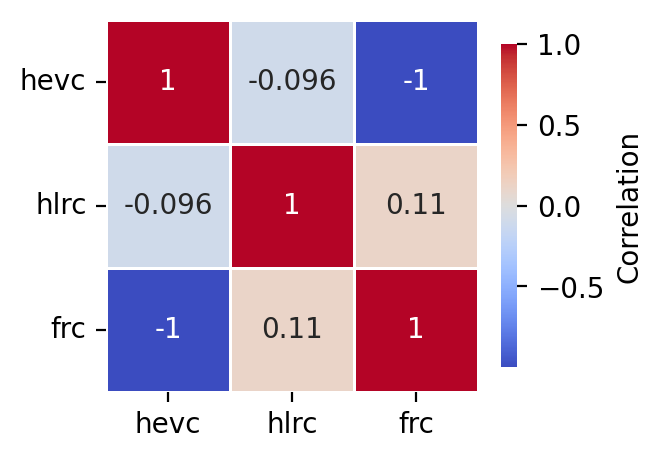

In [32]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sns.heatmap(
    df.corr(),
    square=True,
    lw=1,
    cbar_kws={'shrink' : 0.7, 'label' : 'Correlation'},
    annot=True,
    cmap='coolwarm'
)

plt.yticks(rotation=0)

In [33]:
df.corr()

,hevc,hlrc,frc
hevc,1.000000,-0.095884,-0.999697
hlrc,-0.095884,1.000000,0.109621
frc,-0.999697,0.109621,1.000000


In [15]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
%%time

print(f"{H.shape=}")

node_ev, edge_ev = central.hevc(
    H, 
    function='log-exp', 
    maxiter=10000,
)

df = pd.DataFrame({
    'read_name' : H.columns,
    'hevc' : list(edge_ev),
    'hevc_norm': ut.min_max(edge_ev),  # Assuming you have ut.min_max elsewhere
})

df.head()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5

sns.histplot(
    data=df,
    x='hevc_norm',
)

plt.yscale('log')
sns.despine()

# Add Curvature

In [ ]:
%%time

Hlist = ut.incidence_to_list_of_list(H)
print(f"{len(Hlist)=}")

hlrc = curv.compute_hlrc(Hlist)
print(f"{len(hlrc)=}")

# add edge curvature to dataframe
df['hlrc'] = hlrc
df['hlrc_norm'] = ut.min_max(df['hlrc'])


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2.5

sns.histplot(
    data=df,
    x='hlrc',
)


plt.yscale('log')
sns.despine()

df.head()

In [ ]:
pdf = pd.merge(
    df, adata.var,
    how='left',
    right_index=True,
    left_on='read_name',
)

pdf.head()

In [ ]:
q = 0.01

low_curv = pdf[pdf['hlrc'] < np.percentile(pdf['hlrc'], q)]
print(f"{low_curv.shape=}")

Hhat = adata[:, low_curv['read_name']].to_df().sum(axis=1).reset_index().reset_index()
Hhat.columns = ['index', 'bin_name', 'low_curv_degree']
Hhat['low_curv_degree_log'] = np.log1p(Hhat['low_curv_degree'])
Hhat = pd.concat([Hhat, adata.obs.reset_index().copy()], axis=1)
Hhat['RNA_5'] = np.log1p(Hhat['RNA_5'])
Hhat['index'] = Hhat['index'].astype(int)

columns = [
    'ATACSeq_1',
    # 'ATACSeq_2',
    # 'ATACSeq_3',
    'CTCF',
    'H3K27ac',
    'H3K27me3',
    # 'RNA_1', 
    # 'RNA_2', 
    # 'RNA_3', 
    # 'RNA_4',
    'RNA_5',
    # 'RNA_6', 
    'PolII',
]

for k in columns:

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 10, 2
    x, y = Hhat['index'], Hhat[k]
    sns.lineplot(x=x, y=y, lw=0.5)
    plt.fill_between(x, y, 0, alpha=0.3)

    y2 = Hhat['low_curv_degree_log']
    sns.lineplot(x=x, y=y2, lw=0.5, c='r')
    
    plt.xticks([])
    plt.xlabel("")
    # plt.title(k)
    plt.show()
    

In [ ]:
q = 0.99

low_curv = pdf[pdf['hlrc'] > np.percentile(pdf['hlrc'], q)]
print(f"{low_curv.shape=}")

Hhat = adata[:, low_curv['read_name']].to_df().sum(axis=1).reset_index().reset_index()
Hhat.columns = ['index', 'bin_name', 'low_curv_degree']
Hhat['low_curv_degree_log'] = np.log1p(Hhat['low_curv_degree'])
Hhat = pd.concat([Hhat, adata.obs.reset_index().copy()], axis=1)
Hhat['RNA_5'] = np.log1p(Hhat['RNA_5'])
Hhat['index'] = Hhat['index'].astype(int)

columns = [
    'ATACSeq_1',
    # 'ATACSeq_2',
    # 'ATACSeq_3',
    'CTCF',
    'H3K27ac',
    'H3K27me3',
    # 'RNA_1', 
    # 'RNA_2', 
    # 'RNA_3', 
    # 'RNA_4',
    'RNA_5',
    # 'RNA_6', 
    'PolII',
]

for k in columns:

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 10, 2
    x, y = Hhat['index'], Hhat[k]
    sns.lineplot(x=x, y=y, lw=0.5)
    plt.fill_between(x, y, 0, alpha=0.3)

    y2 = Hhat['low_curv_degree_log']
    sns.lineplot(x=x, y=y2, lw=0.5, c='r')
    
    plt.xticks([])
    plt.xlabel("")
    # plt.title(k)
    plt.show()
    

In [ ]:
adata.obs.columns

In [ ]:
pdf.columns

In [ ]:
break

In [ ]:
hevc_threshold = 0.01
plot_df = pdf[pdf['hevc_norm'] > hevc_threshold].copy()
plot_df = plot_df.sort_values('n_genes')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=plot_df,
    x='hevc_norm',
    y='hlrc',
    ec='none',
    s=10,
    alpha=0.65,
    hue='n_genes',
    palette='coolwarm',
)

plt.axhline(y=0, lw=1, c='k', ls=":")

# Average features

In [ ]:
adata.obs.columns

In [ ]:
%%time

columns = [
    'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
    'CTCF', 'H3K27ac', 'H3K27me3',
    'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6',
    'PolII'
]

# Ensure dense array for indexing
X = adata.X.toarray() if not isinstance(adata.X, np.ndarray) else adata.X

# Result dict: var_name -> mean obs values
result = {}
for i, var_name in tqdm(enumerate(adata.var_names), total=10, desc="Computing means"):
    mask = X[:, i] == 1
    if mask.sum() > 0:
        result[var_name] = adata.obs[columns].loc[mask].mean(numeric_only=True)

# Convert to DataFrame
df_means = pd.DataFrame(result).T
df_means

In [ ]:
%%time
kdf = pd.merge(
    pdf, df_means,
    how='left',
    right_index=True,
    left_on='read_name',
)

kdf.head()

In [ ]:
color_by = 'H3K27ac'
hevc_threshold = 0.01
plot_df = kdf[kdf['hevc_norm'] > hevc_threshold].copy()
plot_df = plot_df.sort_values(color_by)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=plot_df,
    x='hevc_norm',
    y='hlrc',
    ec='none',
    s=10,
    alpha=0.65,
    hue=color_by,
    palette='coolwarm',
)

plt.axhline(y=0, lw=1, c='k', ls=":")

In [ ]:
color_by = 'H3K27me3'
hevc_threshold = 0.01
plot_df = kdf[kdf['hevc_norm'] > hevc_threshold].copy()
plot_df = plot_df.sort_values(color_by)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=plot_df,
    x='hevc_norm',
    y='hlrc',
    ec='none',
    s=10,
    alpha=0.65,
    hue=color_by,
    palette='coolwarm',
)

plt.axhline(y=0, lw=1, c='k', ls=":")

In [ ]:
color_by = 'PolII'
hevc_threshold = 0.01
plot_df = kdf[kdf['hevc_norm'] > hevc_threshold].copy()
plot_df = plot_df.sort_values(color_by)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=plot_df,
    x='hevc_norm',
    y='hlrc',
    ec='none',
    s=10,
    alpha=0.65,
    hue=color_by,
    palette='coolwarm',
)

plt.axhline(y=0, lw=1, c='k', ls=":")

In [ ]:
color_by = 'mean_mapq'
hevc_threshold = 0.01
plot_df = kdf[kdf['hevc_norm'] > hevc_threshold].copy()
plot_df = plot_df.sort_values(color_by)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(
    data=plot_df,
    x='hevc_norm',
    y='hlrc',
    ec='none',
    s=10,
    alpha=0.65,
    hue=color_by,
    palette='coolwarm',
)

plt.axhline(y=0, lw=1, c='k', ls=":")

In [ ]:
break

In [ ]:
# adata.var.head()

In [ ]:
# df.head()

In [ ]:
sns.scatterplot(
    data=df, 
    x='ev',
    y='hlrc',
    s=1,
    ec='none',
)

In [ ]:
break